# Imports

In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchsummary import summary

from IPython.display import clear_output
from tqdm import tqdm
from ipywidgets import interact

from config import device, image_size, batch_size, latent_dim, transform, denormalization, SEX_INDEX, EYEGLASSES_INDEX
from autoencoder import Autoencoder
from helper import show_model, get_avg_by_labels, plot_neighborhood

device

device(type='cuda', index=0)

In [2]:
trainset = torchvision.datasets.CelebA(root='./data', split='train', download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CelebA(root='./data', split='test', download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Convolutional Autoencoder

## Training the model

In [ ]:
model = Autoencoder(latent_dim=latent_dim)
model.to(device)
summary(model, (3, 128, 128))

In [ ]:
model = model.train_autoencoder(model, trainloader, num_epochs=1, learning_rate=1e-3)

In [30]:
torch.save(model.state_dict(), 'autoencoder_lat200.pt')

## Testing the model

In [3]:
AE = Autoencoder(latent_dim=latent_dim)
AE.load_state_dict(torch.load('autoencoder_lat200.pt'))
AE.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ELU(alpha=1.0)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ELU(alpha=1.0)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): ELU(alpha=1.0)
    (9): Linear(in_features=1024, out_features=200, bias=True)
    (10): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=200, out_features=1024, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(64, 4, 4))
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(3, 3), padding=(2, 2))
    (3): ELU(alpha=1.0)
    (4): Upsample(scale_factor=2.0, mode=nearest)
    (5): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), pad

## Test 0: Random images

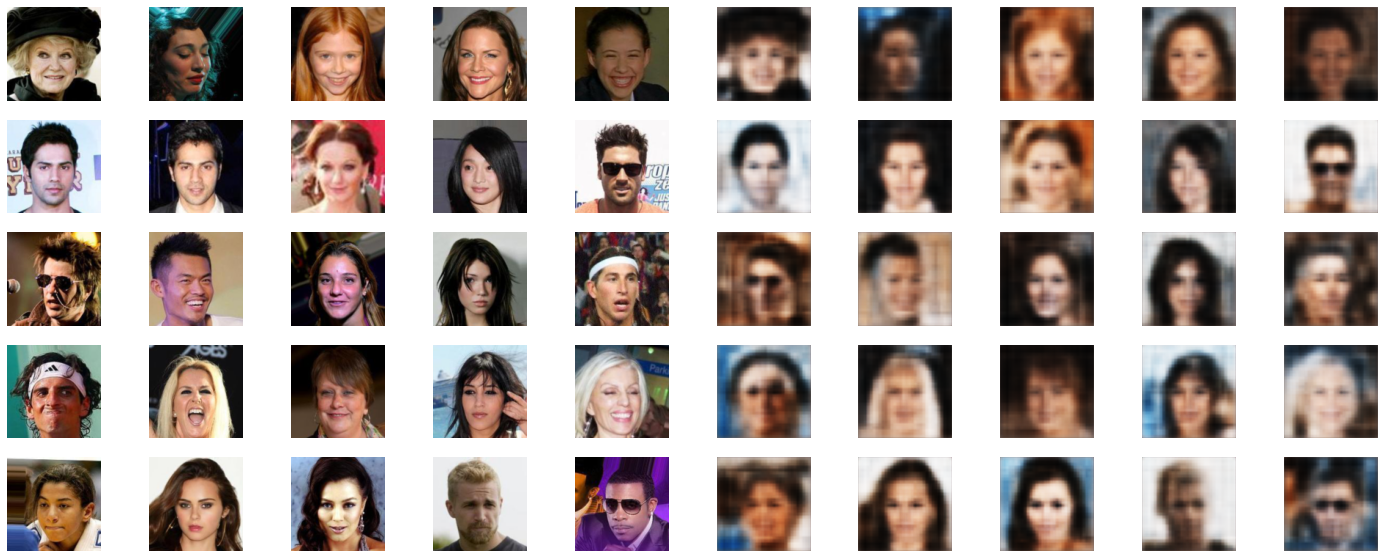

In [4]:
show_model(model=AE, testloader=testloader, n=5)

## Test 1: Latent arithmetic

In [5]:
avg_male_with_glasses = get_avg_by_labels(testset, [SEX_INDEX, EYEGLASSES_INDEX])
avg_male = get_avg_by_labels(testset, [SEX_INDEX])

mask = torch.zeros((testset.attr.shape[1]), dtype=torch.bool)
mask[20] = True
mask = (testset.attr[:, mask] == 0).prod(dim=1).squeeze()
idxs = torch.nonzero(mask)
avg_female = torch.zeros(3, 128, 128)
for i in tqdm(idxs, desc='Getting average female'):
    i.squeeze_()
    avg_female += testset[i][0]
avg_female /= len(idxs)

Getting average female: 100%|██████████| 12247/12247 [00:17<00:00, 711.93it/s]


In [6]:
avg_male_with_glasses_lat = AE.encode(avg_male_with_glasses.unsqueeze(0).to(device))
avg_male_lat = AE.encode(avg_male.unsqueeze(0).to(device))
avg_female_lat = AE.encode(avg_female.unsqueeze(0).to(device))

glass_vector = avg_male_with_glasses_lat - avg_male_lat
avg_female_with_glasses_lat = avg_female_lat + glass_vector
avg_female_with_glasses = AE.decode(avg_female_with_glasses_lat).squeeze(0)
avg_female_rec = AE.decode(avg_female_lat).squeeze(0)

Text(0.5, 1.0, 'Average female reconstruction')

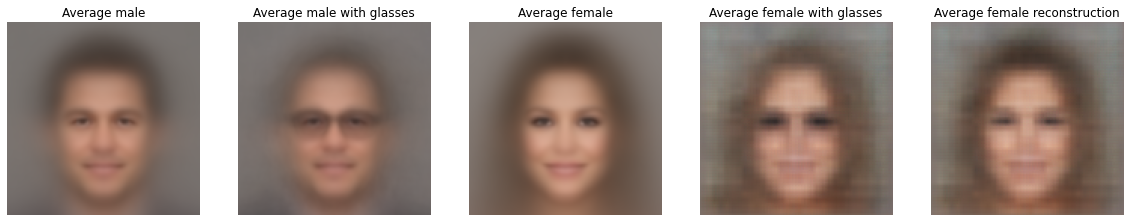

In [7]:
fig, axs = plt.subplots(1, 5, figsize=(20, 10))

axs[0].imshow(denormalization(avg_male).permute(1, 2, 0))
axs[0].axis('off')
axs[0].set_title('Average male')

axs[1].imshow(denormalization(avg_male_with_glasses).permute(1, 2, 0))
axs[1].axis('off')
axs[1].set_title('Average male with glasses')

axs[2].imshow(denormalization(avg_female).permute(1, 2, 0))
axs[2].axis('off')
axs[2].set_title('Average female')

axs[3].imshow(denormalization(avg_female_with_glasses).permute(1, 2, 0).cpu().detach().numpy())
axs[3].axis('off')
axs[3].set_title('Average female with glasses')

axs[4].imshow(denormalization(avg_female_rec).cpu().permute(1, 2, 0))
axs[4].axis('off')
axs[4].set_title('Average female reconstruction')

## Test 2: Interpolation

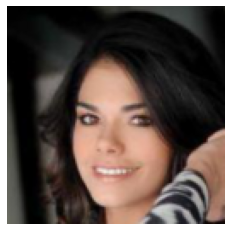

In [8]:
# take a random image from a test set
idx = np.random.randint(len(testset))
img = testset[idx][0]
plt.imshow(denormalization(img).permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()
img = img.unsqueeze(0).to(device)

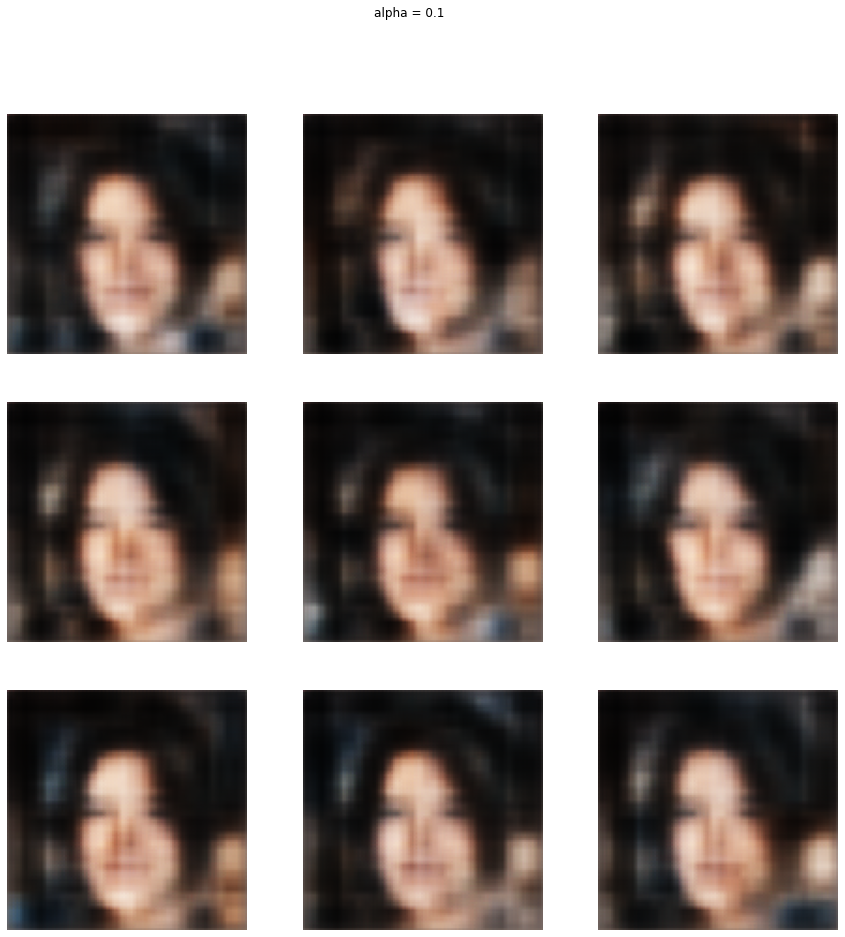

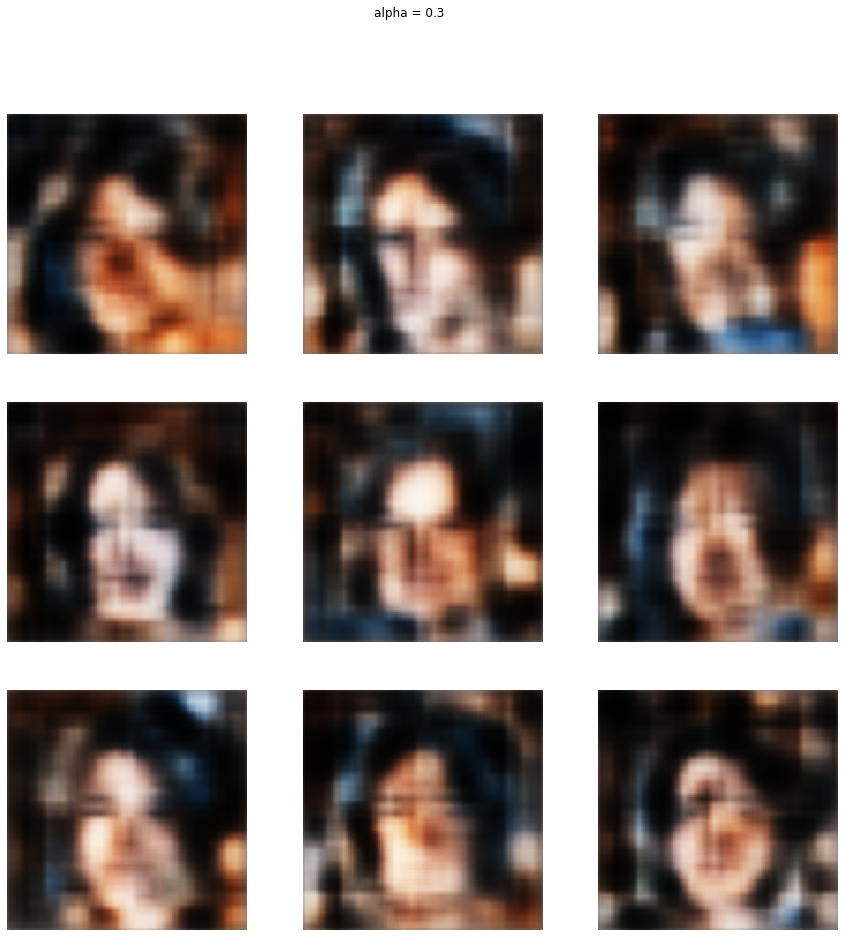

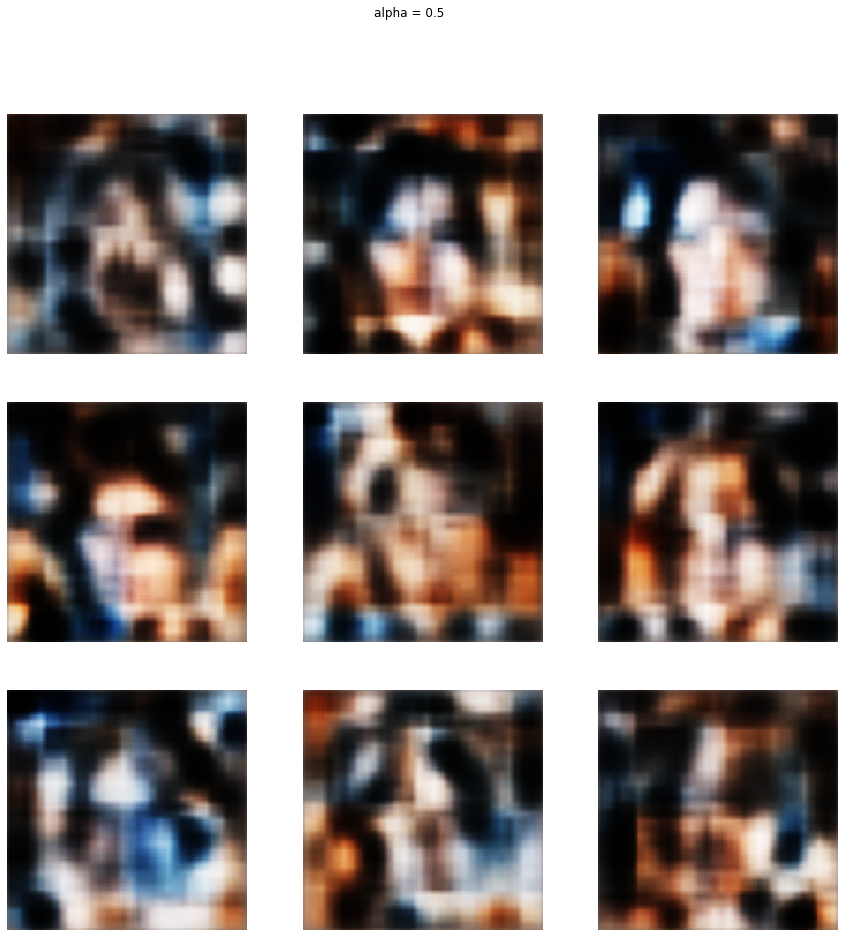

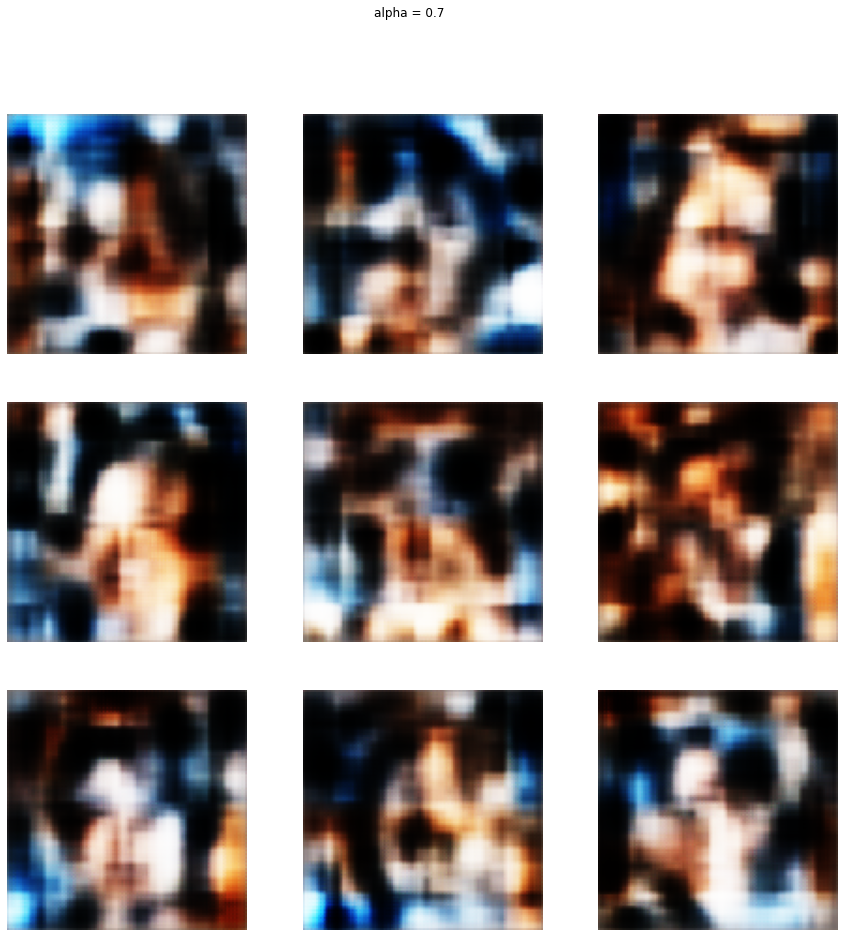

In [11]:
# Use it to see how the neighborhood of the latent space looks like in interactive mode
# @interact(alpha=(0.0, 1.0, 0.1))
# def plot_neighborhood_interact(alpha=0.1):
#     plot_neighborhood(model=AE, img=img, alpha=alpha)

for alpha in np.linspace(0.1, 0.7, 4):
    plot_neighborhood(model=AE, img=img, alpha=alpha, n=3)
    plt.suptitle(f'alpha = {alpha}')

## Test 3: Denoising

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstruction of noisy image')

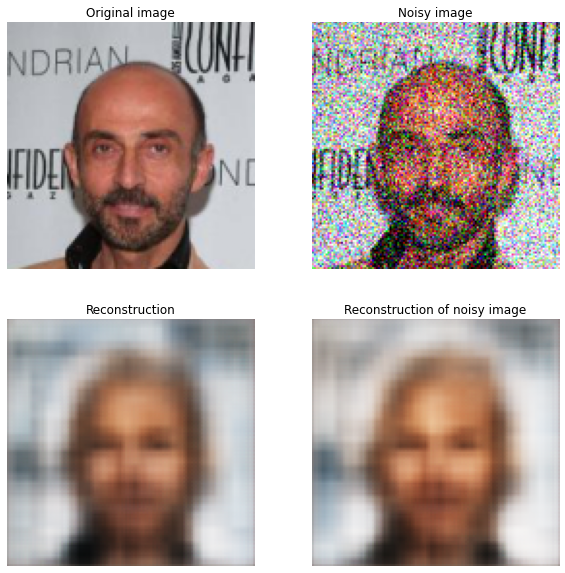

In [12]:
idx = np.random.randint(len(testset))
img = testset[idx][0]
noisy_img = img + torch.randn_like(img) * 0.5


fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0][0].imshow(denormalization(img).permute(1, 2, 0).cpu().numpy())
axs[0][0].axis('off')
axs[0][0].set_title('Original image')

axs[0][1].imshow(denormalization(noisy_img).permute(1, 2, 0).cpu().numpy())
axs[0][1].axis('off')
axs[0][1].set_title('Noisy image')

axs[1][0].imshow(denormalization(AE.decode(AE.encode(img.unsqueeze(0).to(device)))).squeeze().permute(1, 2, 0).cpu().numpy())
axs[1][0].axis('off')
axs[1][0].set_title('Reconstruction')

axs[1][1].imshow(denormalization(AE.decode(AE.encode(noisy_img.unsqueeze(0).to(device)))).squeeze().permute(1, 2, 0).cpu().numpy())
axs[1][1].axis('off')
axs[1][1].set_title('Reconstruction of noisy image')